## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dropout, BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256], drp_ratio=0.1):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [14]:
LEARNING_RATE = 1e-3
EPOCHS = 15 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [9]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [.3, .5, .7]
redice_lr_patient = [5, 10, 15]

In [15]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1) 
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 5
Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
dropout_91 (Dropout)         (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
dropout_92 (Dropout)         (None, 256)               0         
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________


Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 2s 38us/step - loss: 2.2734 - accuracy: 0.1417 - val_loss: 2.1849 - val_accuracy: 0.2184
Epoch 2/15
50000/50000 [==============================] - 2s 35us/step - loss: 2.1503 - accuracy: 0.2152 - val_loss: 2.0656 - val_accuracy: 0.2682
Epoch 3/15
50000/50000 [==============================] - 2s 35us/step - loss: 2.0596 - accuracy: 0.2493 - val_loss: 1.9869 - val_accuracy: 0.2953
Epoch 4/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.9987 - accuracy: 0.2748 - val_loss: 1.9346 - val_accuracy: 0.3177: 2.0026 - accuracy
Epoch 5/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.9551 - accuracy: 0.2945 - val_loss: 1.8961 - val_accuracy: 0.3321
Epoch 6/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.9216 - accuracy: 0.3109 - val_loss: 1.8653 - val_accuracy: 0.3486
Epoch 7/15
50000/50000 [=========================

Epoch 5/15
50000/50000 [==============================] - 2s 38us/step - loss: 1.9692 - accuracy: 0.2866 - val_loss: 1.9084 - val_accuracy: 0.3194
Epoch 6/15
50000/50000 [==============================] - 2s 38us/step - loss: 1.9358 - accuracy: 0.3036 - val_loss: 1.8812 - val_accuracy: 0.3323
Epoch 7/15
50000/50000 [==============================] - 2s 38us/step - loss: 1.9084 - accuracy: 0.3151 - val_loss: 1.8543 - val_accuracy: 0.3452
Epoch 8/15
50000/50000 [==============================] - 2s 38us/step - loss: 1.8838 - accuracy: 0.3235 - val_loss: 1.8324 - val_accuracy: 0.3507
Epoch 9/15
50000/50000 [==============================] - 2s 36us/step - loss: 1.8642 - accuracy: 0.3336 - val_loss: 1.8125 - val_accuracy: 0.3603
Epoch 10/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.8420 - accuracy: 0.3401 - val_loss: 1.7938 - val_accuracy: 0.3646s - loss: 1.8456 - accura
Epoch 11/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.8294 - acc

50000/50000 [==============================] - 2s 35us/step - loss: 1.8686 - accuracy: 0.3307 - val_loss: 1.8176 - val_accuracy: 0.3585: 1.8736 - accuracy: 0.32 - ETA: 0s - loss: 1.8
Epoch 9/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.8484 - accuracy: 0.3388 - val_loss: 1.7977 - val_accuracy: 0.3648
Epoch 10/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.8294 - accuracy: 0.3466 - val_loss: 1.7793 - val_accuracy: 0.3729
Epoch 11/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.8117 - accuracy: 0.3532 - val_loss: 1.7626 - val_accuracy: 0.3780: 1.8123 - accuracy: 0.
Epoch 12/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.7970 - accuracy: 0.3615 - val_loss: 1.7470 - val_accuracy: 0.3802
Epoch 13/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.7841 - accuracy: 0.3650 - val_loss: 1.7327 - val_accuracy: 0.3859
Epoch 14/15
50000/50000 [==============================

50000/50000 [==============================] - 2s 35us/step - loss: 1.8040 - accuracy: 0.3565 - val_loss: 1.7527 - val_accuracy: 0.3807
Epoch 12/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.7860 - accuracy: 0.3645 - val_loss: 1.7345 - val_accuracy: 0.3876
Epoch 13/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.7726 - accuracy: 0.3676 - val_loss: 1.7214 - val_accuracy: 0.3904
Epoch 14/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.7585 - accuracy: 0.3745 - val_loss: 1.7073 - val_accuracy: 0.396327 
Epoch 15/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.7442 - accuracy: 0.3800 - val_loss: 1.6946 - val_accuracy: 0.4002
Numbers of exp: 9, reduce_factor: 0.30, reduce_patient: 5
Model: "model_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_40 (InputLayer)        (None, 3072)              0     

50000/50000 [==============================] - 2s 36us/step - loss: 1.6644 - accuracy: 0.3974 - val_loss: 1.5967 - val_accuracy: 0.4241
Epoch 14/15
50000/50000 [==============================] - 2s 36us/step - loss: 1.6526 - accuracy: 0.4003 - val_loss: 1.5883 - val_accuracy: 0.4304
Epoch 15/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.6462 - accuracy: 0.4051 - val_loss: 1.5833 - val_accuracy: 0.4322
Numbers of exp: 11, reduce_factor: 0.30, reduce_patient: 15
Model: "model_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_42 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
dropout_124 (Dropout)        (None, 256)               0         
____________________________

Epoch 15/15
50000/50000 [==============================] - 2s 39us/step - loss: 1.5944 - accuracy: 0.4276 - val_loss: 1.5467 - val_accuracy: 0.4488
Numbers of exp: 13, reduce_factor: 0.50, reduce_patient: 10
Model: "model_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
dropout_130 (Dropout)        (None, 256)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
dropout_131 (Dropout)        (None, 256)               0         
________________________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/15
50000/50000 [==============================] - 2s 47us/step - loss: 2.5267 - accuracy: 0.1681 - val_loss: 1.9672 - val_accuracy: 0.2649
Epoch 2/15
50000/50000 [==============================] - 2s 36us/step - loss: 1.9616 - accuracy: 0.2704 - val_loss: 1.8446 - val_accuracy: 0.3202- loss: 1.9678 - accuracy: 0.
Epoch 3/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.8722 - accuracy: 0.3138 - val_loss: 1.7710 - val_accuracy: 0.3653
Epoch 4/15
50000/50000 [==============================] - 2s 36us/step - loss: 1.8276 - accuracy: 0.3377 - val_loss: 1.7174 - val_accuracy: 0.3919
Epoch 5/15
50000/50000 [==============================] - 2s 35us/step - loss: 1.7868 - accuracy: 0.3548 - val_loss: 1.6867 - val_accuracy: 0.3996
Epoch 6/15
50000/50000 [==============================] - 2s 38us/step - loss: 1.7546 - accuracy: 0.3666 - val_loss: 1.6597 - val_accuracy: 0.4093
Epoch 7/15
50000/50000 [===============

50000/50000 [==============================] - 2s 41us/step - loss: 1.8638 - accuracy: 0.3217 - val_loss: 1.7600 - val_accuracy: 0.3657
Epoch 4/15
50000/50000 [==============================] - 2s 45us/step - loss: 1.8112 - accuracy: 0.3449 - val_loss: 1.7220 - val_accuracy: 0.3831
Epoch 5/15
50000/50000 [==============================] - 2s 47us/step - loss: 1.7760 - accuracy: 0.3590 - val_loss: 1.6776 - val_accuracy: 0.3965
Epoch 6/15
50000/50000 [==============================] - 2s 44us/step - loss: 1.7476 - accuracy: 0.3698 - val_loss: 1.6549 - val_accuracy: 0.4097
Epoch 7/15
50000/50000 [==============================] - 2s 41us/step - loss: 1.7305 - accuracy: 0.3728 - val_loss: 1.6496 - val_accuracy: 0.4100
Epoch 8/15
50000/50000 [==============================] - 2s 38us/step - loss: 1.7060 - accuracy: 0.3843 - val_loss: 1.6348 - val_accuracy: 0.4141
Epoch 9/15
50000/50000 [==============================] - 2s 38us/step - loss: 1.6891 - accuracy: 0.3889 - val_loss: 1.6080 - val

50000/50000 [==============================] - 2s 35us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000s: nan - accuracy: 0 - ETA: 0s - loss: nan - accuracy: 0.09
Epoch 7/15
50000/50000 [==============================] - 2s 36us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 8/15
50000/50000 [==============================] - 2s 37us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000: 0s - loss: nan - accuracy: 0.09
Epoch 9/15
50000/50000 [==============================] - 2s 36us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000oss: nan - accuracy
Epoch 10/15
50000/50000 [==============================] - 2s 37us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000A: 0s - loss: nan - accuracy: 0.1

Epoch 00010: ReduceLROnPlateau reducing learning rate to 8.505000778313842e-07.
Epoch 11/15
50000/50000 [==============================] - 2s 37us/step - loss: 

50000/50000 [==============================] - 2s 35us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000 loss: nan - accurac
Epoch 9/15
50000/50000 [==============================] - 2s 35us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000A: 0s - loss: nan - ac
Epoch 10/15
50000/50000 [==============================] - 2s 39us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000

Epoch 00010: ReduceLROnPlateau reducing learning rate to 6.378751038482733e-08.
Epoch 11/15
50000/50000 [==============================] - 2s 47us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 12/15
50000/50000 [==============================] - 2s 42us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 13/15
50000/50000 [==============================] - 2s 35us/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 14/15
50000/50000 [=============

Epoch 10/15
50000/50000 [==============================] - 2s 38us/step - loss: 2.4170 - accuracy: 0.0982 - val_loss: 2.4194 - val_accuracy: 0.0999
Epoch 11/15
50000/50000 [==============================] - 2s 40us/step - loss: 2.4177 - accuracy: 0.0999 - val_loss: 2.3541 - val_accuracy: 0.0842
Epoch 12/15
50000/50000 [==============================] - 2s 39us/step - loss: 2.4163 - accuracy: 0.1012 - val_loss: 2.4288 - val_accuracy: 0.0997
Epoch 13/15
50000/50000 [==============================] - 2s 37us/step - loss: 2.4171 - accuracy: 0.1002 - val_loss: 2.3567 - val_accuracy: 0.1004
Epoch 14/15
50000/50000 [==============================] - 2s 35us/step - loss: 2.4209 - accuracy: 0.1010 - val_loss: 2.4238 - val_accuracy: 0.1000 accu - ETA: 0s - loss: 2.4220 - accuracy: 0.10 - ETA: 0s - loss: 2.4215 - accuracy: 0.10
Epoch 15/15
50000/50000 [==============================] - 2s 35us/step - loss: 2.4104 - accuracy: 0.1010 - val_loss: 2.3985 - val_accuracy: 0.1001
Numbers of exp: 24, red

50000/50000 [==============================] - 2s 38us/step - loss: 2.3936 - accuracy: 0.1019 - val_loss: 2.4179 - val_accuracy: 0.0998
Epoch 13/15
50000/50000 [==============================] - 2s 38us/step - loss: 2.3991 - accuracy: 0.1018 - val_loss: 2.3493 - val_accuracy: 0.1069
Epoch 14/15
50000/50000 [==============================] - 2s 38us/step - loss: 2.3977 - accuracy: 0.1031 - val_loss: 2.4295 - val_accuracy: 0.0998
Epoch 15/15
50000/50000 [==============================] - 2s 37us/step - loss: 2.3979 - accuracy: 0.1009 - val_loss: 2.3498 - val_accuracy: 0.1003
Numbers of exp: 26, reduce_factor: 0.70, reduce_patient: 15
Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
____________

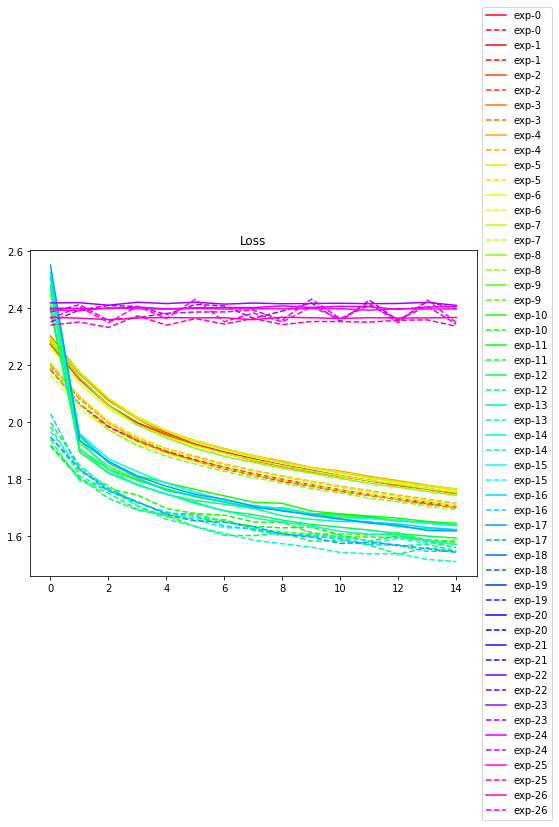

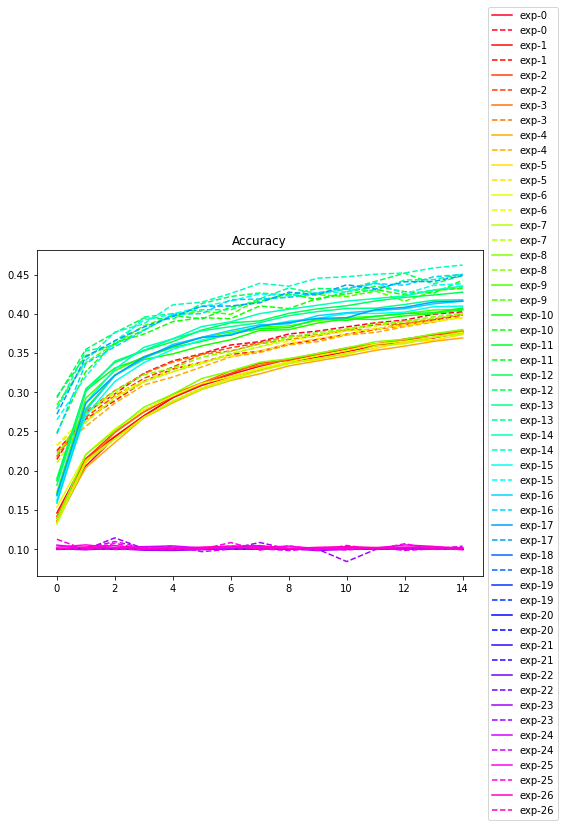

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()